# Twitter Sentiment Analysis with BERT and Naive Bayes

This project focuses on binary sentiment classification of tweets using the Sentiment140 dataset, which contains 1.6 million tweets labeled as positive or negative. The goal was to build a complete NLP pipeline, starting with a classical machine learning approach and progressing to a state-of-the-art deep learning model.

The first part of the work uses a **TF-IDF + Multinomial Naive Bayes** pipeline to establish a baseline model. This traditional approach provides fast training and interpretable results, achieving solid performance on this large-scale dataset.

The second part leverages **BERT** (Bidirectional Encoder Representations from Transformers) to capture contextual information in tweets. The model is fine-tuned on a subset of 200,000 tweets for efficiency, significantly improving classification accuracy compared to the baseline.

This comparison highlights the trade-offs between classical and modern NLP approaches in terms of accuracy, training time, and computational cost, providing insights into model selection for real-world sentiment analysis tasks.

## Summary
1. Import and Prepare the Dataset

2. Exploratory Data Analysis (EDA)

3. Models
- Baseline Model: TF-IDF + Naive Bayes
- Transformer Model: BERT Fine-tuning

4. Save Models

5. Model Testing and Comparison

## 1. Import and Prepare the Dataset

Load the dataset and assign appropriate column names based on the file format.

In [1]:
import re
from huggingface_hub import hf_hub_download
import pandas as pd

c:\Users\User\OneDrive\Bureau\Projects\twitter_sentiment_analysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
file_path = hf_hub_download(
    repo_id="nasserCha/twitter_sentiment_analysis",
    filename="sentiment140.csv",
    repo_type="dataset"
)

df = pd.read_csv(
    file_path,
    encoding='latin1',
    header=None,
    names=['target', 'id', 'date', 'flag', 'user', 'text']
)

c:\Users\User\OneDrive\Bureau\Projects\twitter_sentiment_analysis\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\datasets--nasserCha--twitter_sentiment_analysis. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


The dataset contains 1.6M tweets with 6 columns:
- target: 0 = negative, 1 = positive
- id: tweet identifier
- date: date of the tweet
- flag: query used to collect the tweet (or NO_QUERY if none)
- user: author username
- text: tweet content

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [4]:
df.describe()

,target,id
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


In [5]:
df['target'].value_counts()

,count
target,
0,800000
4,800000


In [6]:
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


The dataset is balanced between the two sentiment classes, 0 and 4.

In [7]:
df['target'].value_counts()

,count
target,
0,800000
4,800000


I replaced 0 and 4 with 0 and 1 to have two binary classes. This simplifies training and improves compatibility with most models.

In [8]:
df['target'] = df['target'].replace({0: 0, 4: 1})

I cleaned the text by removing URLs, the mentions (@), the ponctuation and the special character.

In [63]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

In [64]:
df['clean_text'] = df['text'].apply(clean_text)

## 2. Exploratory Data Analysis

I explored the data and checked for potential correlations to prepare for model building.

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

I analyzed the relationship between tweet length and sentiment to see if the number of words influences the target class.

In [ ]:
df['text length'] = df['text'].apply(len)

The distribution of tweet lengths is almost identical for both sentiment classes. Therefore, tweet length will not be used as a predictive feature in the models.

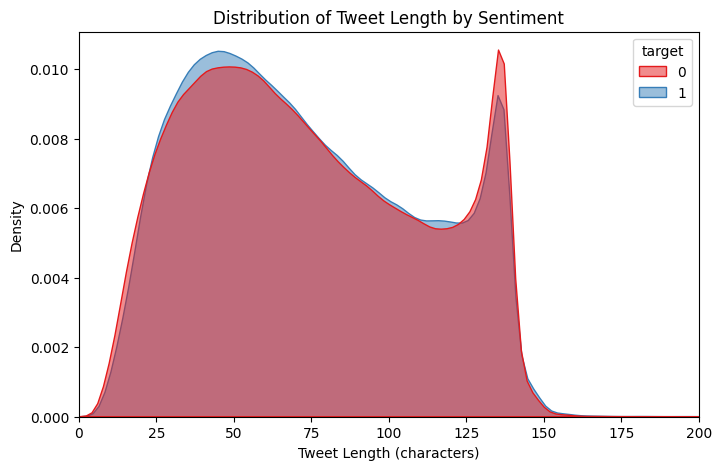

In [68]:
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df, x='text length', hue='target', fill=True, common_norm=False, palette='Set1', alpha=0.5)
plt.title('Distribution of Tweet Length by Sentiment')
plt.xlabel('Tweet Length (characters)')
plt.ylabel('Density')
plt.xlim(0, 200)
plt.show()

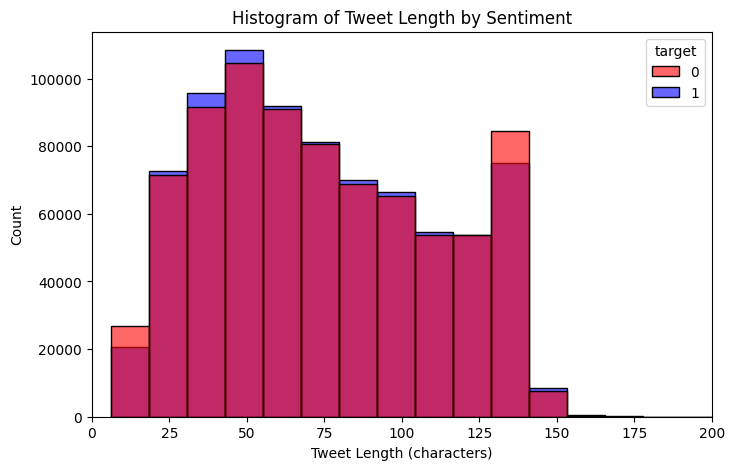

In [69]:
plt.figure(figsize=(8,5))
sns.histplot(
    data=df,
    x='text length',
    hue='target',
    bins=30,
    kde=False,
    stat="count",
    palette={0: "red", 1: "blue"},
    alpha=0.6
)

plt.title("Histogram of Tweet Length by Sentiment")
plt.xlabel("Tweet Length (characters)")
plt.ylabel("Count")
plt.xlim(0, 200)
plt.show()

In [71]:
df.drop(columns=['text length'], inplace=True)

I removed the columns **flag**, **id**, **date**, and **user** because they either contain constant values or are identifiers that do not provide any predictive information for the sentiment analysis task.

In [59]:
print(df['flag'].value_counts())

flag
NO_QUERY    1600000
Name: count, dtype: int64


In [60]:
print(df['id'].nunique())

1598315


In [61]:
print(df['date'].nunique())

774363


In [62]:
print(df['user'].nunique())

659775


In [70]:
df = df.drop(columns=['id', 'user', 'flag', 'date'])

## 3. Models
### a. Baseline Model: TF-IDF + Naive Bayes


This baseline model is quick to train and provides a reference point for performance.  
It uses TF-IDF to convert text into numerical features and a Multinomial Naive Bayes classifier, which is well-suited for text classification tasks.

In [12]:
X = df['clean_text']
y = df['target']

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

I created a pipeline that first converts the text into a bag-of-words representation with unigrams and bigrams (up to 5,000 features), then applies TF-IDF transformation, and finally trains a Multinomial Naive Bayes classifier.

In [15]:
from sklearn.feature_extraction.text import  TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

In [16]:
pipeline = Pipeline([
    ('bow', CountVectorizer(max_features=5000, ngram_range=(1,2))),  # ajout bigrammes
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB()),
])

In [17]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('bow', CountVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [18]:
predictions = pipeline.predict(X_test)

In [19]:
from sklearn.metrics import confusion_matrix,classification_report

The baseline model achieved an accuracy of **77%**, with balanced performance across both classes:  
- Class 0 (negative): Precision = 0.77, Recall = 0.79, F1-score = 0.78  
- Class 1 (positive): Precision = 0.78, Recall = 0.76, F1-score = 0.77  

These results indicate that the TF-IDF + Multinomial Naive Bayes pipeline performs reasonably well on the dataset, providing a solid reference point for evaluating more advanced models such as BERT.


In [20]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[125567  33927]
 [ 38428 122078]]
              precision    recall  f1-score   support

           0       0.77      0.79      0.78    159494
           1       0.78      0.76      0.77    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



### b. Transformer Model: BERT Fine-tuning


**BERT** (Bidirectional Encoder Representations from Transformers) is a deep learning model developed by Google that revolutionized Natural Language Processing (NLP).  
Unlike traditional models that read text in one direction (left-to-right or right-to-left), BERT reads text **bidirectionally**, meaning it captures the full context of each word based on all surrounding words.

BERT is pre-trained on a large corpus of text using two main tasks:
- **Masked Language Modeling (MLM)**: Randomly masks words in a sentence and trains the model to predict them.
- **Next Sentence Prediction (NSP)**: Predicts whether a sentence logically follows another.

This pre-training enables BERT to understand language at a much deeper level.  
For this project, we fine-tune the **`bert-base-uncased`** version specifically for binary sentiment classification of tweets, allowing it to adapt its learned representations to our dataset.



In [72]:
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import classification_report
import numpy as np
import os
os.environ["WANDB_DISABLED"] = "true"

In [22]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


I created the **TweetDataset class** to convert the tweets and their labels into a PyTorch-compatible format, including tokenization and encoding for input into the BERT model.

In [23]:
class TweetDataset(Dataset):

    def __init__(self, texts, labels, tokenizer, max_length=64):

        self.encodings = tokenizer(
            list(texts),
            truncation=True,
            padding=True,
            max_length=max_length
        )
        self.labels = list(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

I sampled 200,000 tweets from the dataset to reduce training time and computational cost while keeping a representative subset for fine-tuning BERT.

In [24]:
df_sample = df.sample(n=200000, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    df_sample['clean_text'], df_sample['target'],
    test_size=0.5, random_state=42
)

In [25]:
train_dataset = TweetDataset(X_train, y_train, tokenizer, max_length=64)
test_dataset  = TweetDataset(X_test, y_test, tokenizer, max_length=64)

In [26]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=100,
    load_best_model_at_end=True,
    report_to="none"
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [35]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    report = classification_report(labels, preds, output_dict=True)
    return {
        'accuracy': report['accuracy'],
        'precision_0': report['0']['precision'],
        'recall_0': report['0']['recall'],
        'f1_0': report['0']['f1-score'],
        'precision_1': report['1']['precision'],
        'recall_1': report['1']['recall'],
        'f1_1': report['1']['f1-score']
    }

In [ ]:
trainer = Trainer(
    model=model,ss
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)
trainer.train()

In [77]:
predictions = trainer.predict(test_dataset)
y_pred_bert = np.argmax(predictions.predictions, axis=1)
print(classification_report(y_test, y_pred_bert))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     49939
           1       0.83      0.83      0.83     50061

    accuracy                           0.83    100000
   macro avg       0.83      0.83      0.83    100000
weighted avg       0.83      0.83      0.83    100000



## 4. Save Models

### a. Baseline Model

In [18]:
import pickle

In [ ]:
with open("./models/nb_tfidf_pipeline.pkl", "wb") as f:
    pickle.dump(pipeline, f, protocol=4) 

['/content/drive/My Drive/nb_tfidf_pipeline.joblib']

### b. Transformer Model

In [ ]:
model.save_pretrained("./models/bert_sentiment_model")
tokenizer.save_pretrained("./models/bert_sentiment_model")

('/content/drive/My Drive/bert_sentiment_model/tokenizer_config.json',
 '/content/drive/My Drive/bert_sentiment_model/special_tokens_map.json',
 '/content/drive/My Drive/bert_sentiment_model/vocab.txt',
 '/content/drive/My Drive/bert_sentiment_model/added_tokens.json')

## 5. Model Testing and Comparison

The baseline **TF-IDF + Multinomial Naive Bayes** model achieved an accuracy of **77%**.  
Its precision, recall, and F1-score were balanced between the two classes but showed limitations in capturing more complex contextual relationships in the tweets.

The **BERT** model, fine-tuned on 200,000 tweets, achieved an accuracy of **83%**, representing a clear improvement of **6 percentage points** over the baseline.  
BERT delivered higher precision, recall, and F1-scores across both classes, demonstrating its superior ability to handle context and nuanced language.

**Summary:**
- **Naive Bayes**: Fast to train, interpretable, lower accuracy.
- **BERT**: Slower and more resource-intensive, but significantly more accurate and better at capturing sentiment nuances.

| Model                          | Accuracy | F1-score | Notes |
|--------------------------------|----------|----------|-------|
| TF-IDF + Multinomial Naive Bayes | 0.77     | 0.77     | Fast, interpretable, but limited in context understanding |
| BERT Fine-Tuning               | 0.83     | 0.83     | Slower, resource-intensive, but better at capturing nuanced sentiment |


In [12]:
label_map = {0: "Negative", 1: "Positive"}
text = "I love it"

### a. Baseline Model

In [21]:
pipeline_loaded = pickle.load(open("./models/nb_tfidf_pipeline.pkl", "rb"))
pred_class = pipeline_loaded.predict([text])[0]  # extraire la valeur


print(f"Text: {text}")
print(f"Predicted class: {label_map[pred_class]}")

Text: I love it
Predicted class: Positive


### b. Transformer Model

In [16]:
from transformers import BertForSequenceClassification, BertTokenizer
from torch.nn import functional as F

In [17]:
model_loaded = BertForSequenceClassification.from_pretrained("./models/bert_sentiment_model")
tokenizer_loaded = BertTokenizer.from_pretrained("./models/bert_sentiment_model")

inputs = tokenizer_loaded(text, return_tensors="pt")

outputs = model_loaded(**inputs)
probs = F.softmax(outputs.logits, dim=-1)

pred_class = torch.argmax(probs, dim=1).item()
pred_proba = probs[0][pred_class].item()



print(f"Text: {text}")
print(f"Predicted class: {label_map[pred_class]} ({pred_proba:.2%} confidence)")


Text: I love it
Predicted class: Positive (96.33% confidence)
